# Calculating an Inflow Coefficient

Load packages and data.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

# To import the self made functions you need to fill in the path were you 
# saved the functions instead of the word 'Code'
import sys
sys.path.append('C:\\Users\\20174814\\Documents\\2019-2020\\Data challenge 3\\JBG060-Data-Challenge-3-master\\code')

import Utility.load_files as lf
import Utility.flow_level_conversion as flc
import Utility.preprocessing
import Utility.utility

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Fill the right directories for the data for Aa en Maas in here.
PATH = 'C:\\Users\\20174814\\Documents\\2019-2020\\Data challenge 3\\' # CHANGE (!)
PATH_MEASUREMENTS = PATH + "sewer_data\\data_pump\\RG8150"
PATH_RAIN_DATA = PATH + "sewer_data\\rain_timeseries"
PATH_SHAPE_FILES = PATH + "sewer_model\\aa-en-maas_sewer_shp"

In [2]:
# LOADING NECESSARY DATA
# Measurements
flow_data, level_data = lf.get_measurements(PATH_MEASUREMENTS)

# Actual rain
rain_data = lf.get_rain(PATH_RAIN_DATA)

# Shape file data frames
data = lf.sdf(PATH_SHAPE_FILES)

Calculate flow peaks, level drops and additional measurements.

In [3]:
# Prepare data internally
coeff = flc.generate_coefficient(flow_data, level_data)

# We decide to only focus on dry days
coeff.to_dry_data(rain_data, data.area_data, min_dry_series=2, village_code="DRU", dry_threshold=2.5)

# We add groups that can be analyzed later
coeff.add_groups()

### Polynomial Regression

In [151]:
# We try to isolate only regular peak patterns and delete outliers
x = coeff.flow_groups.loc[(coeff.flow_groups["Flow"].between(30,100)) &
                          (coeff.flow_groups["AdjDelta"].between(-4,-1)) &
                          (coeff.flow_groups["TimeSpan"].between(100, 1000)) &
                          (coeff.flow_groups["max_level"].between(-0.25, -0.175))].iloc[2:]

# Select data for OLS
y = x["AdjDelta"]
X = pd.concat([x["Flow"], x["Flow"]**2], axis=1)
X.columns = ["Flow", "Flow squared"]

# Fit OLS
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               AdjDelta   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          4.113e+05
Date:                Tue, 22 Oct 2019   Prob (F-statistic):                        0.00
Time:                        13:34:48   Log-Likelihood:                          2945.2
No. Observations:                3444   AIC:                                     -5886.
Df Residuals:                    3442   BIC:                                     -5874.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Flow            -0.0291      0.001    -20.758      0.000      -0.032      -0.026
Flow squared    -0.0002   3.22e-05     -5.391      0.000      -0.000      -0.000
==============================================================================
Omnibus:                      250.092   Durbin-Watson:                   1.576
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1225.482
Skew:                          -0.129   Prob(JB):                    7.76e-267
Kurtosis:                       5.911   Cond. No.                     1.51e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Plot Results

Text(0.5, 0, 'Flow')

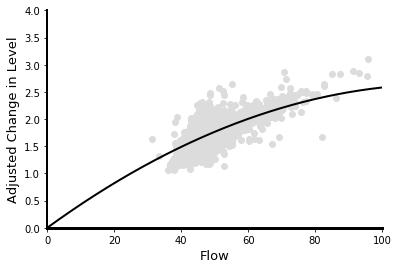

In [149]:
# Visualize results
fig, ax = plt.subplots()

plt.xlim(0,100)
plt.ylim(0,4)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(3)

sim_X = pd.DataFrame({"Flow": np.linspace(0,100,10000)})
sim_X["Flow squared"] = sim_X["Flow"]**2

into = sim_X["Flow"].sort_values()
out = results.predict(sim_X.sort_values("Flow")).values

plt.scatter(x["Flow"], abs(x["AdjDelta"]), color= "gainsboro")
ax.plot(into, abs(out), color="black", linewidth=2)

plt.ylabel("Adjusted Change in Level", size=13)
plt.xlabel("Flow", size=13)